In [1]:
import numpy as np
import xarray as xr
import pickle
import pandas as pd
import time
import os

from collections import OrderedDict

import datetime
from sys import getsizeof,path

import matplotlib.pyplot as plt
import matplotlib

path.append("../src")
from Splines import CentripetalCatmullRomSpline_splitControls,Spline
import Cases
from Population import ImportPopulation
from ModelParams import ObservedData,ModelParam



In [2]:
matplotlib.rcParams['figure.figsize'] = [12, 6]

In [3]:
df = pd.read_csv("../Data/Deaths/COVID-19_Todesfaelle_10y_211014.csv",sep=";",na_values="<4")
df = df.fillna(2).astype("int64")
df.index = range(10,len(df)+10)

f = {"AG 90+ Jahre":90}
for i in range(9):
    f["AG %d-%d Jahre"%(i*10,i*10+9)] = i*10

week_of_death = df.rename(columns=f)
print(week_of_death)

    Sterbejahr  Sterbewoche  0  10  20  30  40  50   60   70   80   90
10        2020           10  0   0   0   0   0   2    2    0    0    0
11        2020           11  0   0   0   0   0   0    2    6   11    0
12        2020           12  0   0   0   0   2   8    7   36   85   25
13        2020           13  0   0   2   2   7  19   60  143  294   74
14        2020           14  0   0   2   5   9  55  127  320  592  260
..         ...          ... ..  ..  ..  ..  ..  ..  ...  ...  ...  ...
87        2021           34  2   0   0   2   6   8   25   36   54   26
88        2021           35  0   0   0   6  15  23   33   48   85   45
89        2021           36  0   2   2   2  18  24   39   66   98   59
90        2021           37  0   0   6   4  21  29   38   79  147   65
91        2021           38  0   2   2  11  13  36   45   85  122   43

[82 rows x 12 columns]


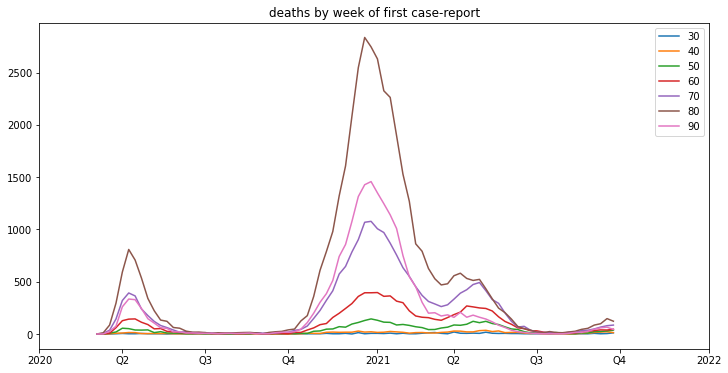

In [4]:
week_of_death.filter([30,40,50,60,70,80,90]).plot()
plt.xticks([1,14,27,40,54,66,79,92,53*2],labels=[2020,"Q2","Q3","Q4",2021,"Q2","Q3","Q4",2022])
_ = plt.title("deaths by week of first case-report")

    Meldejahr  Meldewoche   0   5   15    35    60    80
10       2020          10   2   3   23    84    37    11
11       2020          11   2   2   54   238   152    77
12       2020          12  14   6  152   725   861   472
13       2020          13  32  16  259  1359  2219  1259
14       2020          14  27  17  305  1346  2488  1917
..        ...         ...  ..  ..  ...   ...   ...   ...
89       2021          36  95  82  532  1114   746   521
90       2021          37  75  52  439   928   614   501
91       2021          38  69  55  372   772   614   449
92       2021          39  63  50  342   689   568   517
93       2021          40  42  40  226   493   529   475

[84 rows x 8 columns]


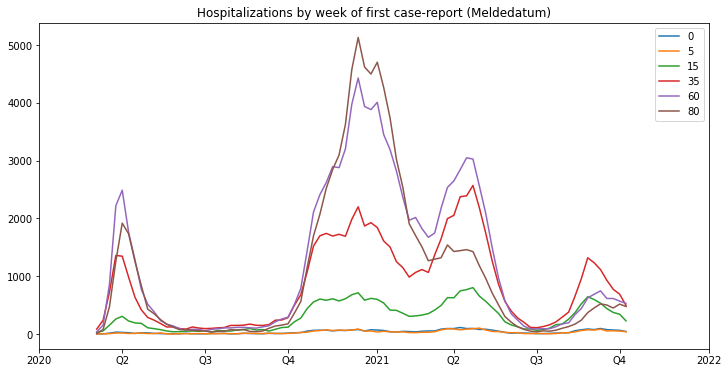

In [6]:
df = pd.read_csv("../Data/Cases/SitRep_RKI/Hospitalisierung_Altersverteilung_211013.csv",sep=";",header=4)
#df = df.astype("int64")

f = {"Fälle A00..04":0,"Fälle A05..14":5,"Fälle A15..34":15,"Fälle A35..59":35,"Fälle A60..79":60,"Fälle A80+":80}
df = df.rename(columns=f)
df.index = range(10,len(df)+10)
meldedatum_hospitalization = df.filter(["Meldejahr","Meldewoche"]+list(f.values())).fillna(0).astype("int64")

meldedatum_hospitalization.filter([0,5,15,35,60,80]).plot()
plt.xticks([1,14,27,40,54,66,79,92,53*2],labels=[2020,"Q2","Q3","Q4",2021,"Q2","Q3","Q4",2022])
plt.title("Hospitalizations by week of first case-report (Meldedatum)")

print(meldedatum_hospitalization)

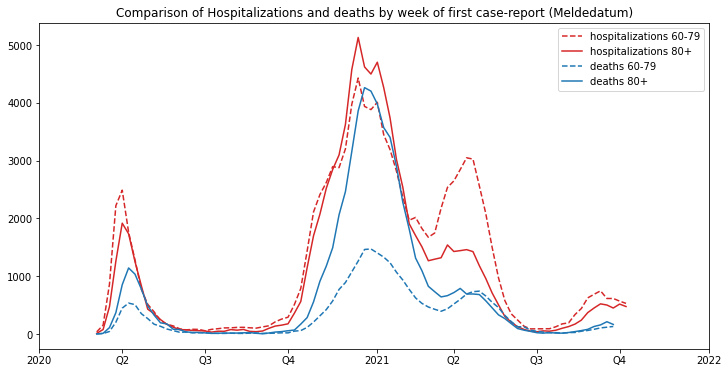

In [7]:
plt.plot(meldedatum_hospitalization.filter([60]),"--",color="tab:red",label="hospitalizations 60-79")
plt.plot(meldedatum_hospitalization.filter([80]),color="tab:red",label="hospitalizations 80+")

plt.plot(week_of_death[60]+week_of_death[70],"--",color="tab:blue",label="deaths 60-79")
plt.plot(week_of_death[80]+week_of_death[90],color="tab:blue",label="deaths 80+")
#plt.plot(week_of_death.filter([80]),color="tab:blue")
plt.title("Comparison of Hospitalizations and deaths by week of first case-report (Meldedatum)")
plt.legend()
_ = plt.xticks([1,14,27,40,54,66,79,92,53*2],labels=[2020,"Q2","Q3","Q4",2021,"Q2","Q3","Q4",2022])

In [8]:
path.append("../Data/Deaths/SitRep_RKI")
from CopiedData import DeathsPerAG

In [9]:
# cuml. reportet death at each tuesday
DeathsPerAG()

4268 Datapoints


<xarray.DataArray (date: 194, sex: 2, age: 11)>
array([[[    0,     1,     3, ...,  1399,   376,     3],
        [    1,     0,     2, ...,  1206,   643,    32]],

       [[    0,     1,     4, ...,  1437,   382,     4],
        [    1,     0,     2, ...,  1250,   658,    32]],

       [[    0,     1,     4, ...,  1479,   390,     4],
        [    1,     0,     2, ...,  1296,   689,    33]],

       ...,

       [[    4,     6,    62, ..., 21022,  6704,     0],
        [   11,     6,    36, ..., 20283, 12876,     0]],

       [[    4,     6,    63, ..., 21204,  6757,     0],
        [   11,     7,    36, ..., 20403, 12950,     0]],

       [[    4,     6,    63, ..., 21107,  6727,     0],
        [   11,     6,    36, ..., 20338, 12913,     0]]], dtype=int32)
Coordinates:
  * age      (age) int64 0 10 20 30 40 50 60 70 80 90 100
  * sex      (sex) <U6 'male' 'female'
  * date     (date) object 2020-04-27 2020-04-28 ... 2021-10-05 2021-10-06

In [10]:
df = pd.read_csv("../Data/Deaths/DeathsRKI_fromArcgis.csv",sep=",",parse_dates=["Meldedatum","Refdatum","TodesMeldedatum"])
df = df.filter(["Altersgruppe","Geschlecht","AnzahlFall","AnzahlTodesfall","TodesMeldedatum"])

n = 110
ages = OrderedDict()
for k,v in zip(("A00-A04","A05-A14","A15-34","A35-A59","A60-A79","A80+"),(0,5,15,35,60,80)):
    ages[k] = v
data = np.zeros((n,2,len(ages),),dtype="int64")

weeks = pd.date_range("2019-12-30", periods=n, freq="W-MON")
for i,w1,w2 in zip(range(0,n),weeks[:-1],weeks[1:]):
    wmask = (df["TodesMeldedatum"] >= w1) & (df["TodesMeldedatum"] < w2)
    reported_deaths_in_week = df[wmask]
    
    for j,sex in enumerate(["M","W"]):
        reported_deaths_in_week_sex = reported_deaths_in_week[reported_deaths_in_week["Geschlecht"]==sex]
        for k,age in enumerate(ages.keys()):
            reported_deaths_in_week_sex_age = reported_deaths_in_week_sex[reported_deaths_in_week_sex["Altersgruppe"]==age]
            deaths = reported_deaths_in_week_sex_age["AnzahlTodesfall"].sum()
            data[i,j,k] = deaths

reported_deaths = xr.DataArray(data,dims=["week","sex","age"],coords={"week":range(1,n+1),"sex":["M","W"],"age":list(ages.values())})

In [21]:
reported_deaths.sum("sex").sel(week=range(10,95))

<xarray.DataArray (week: 85, age: 6)>
array([[   0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0],
       [   0,    0,    0,   10,   56,  125],
       [   0,    0,    0,   25,  182,  296],
       [   1,    0,    0,   65,  445,  849],
       [   0,    0,    0,   65,  517, 1047],
       [   2,    0,    0,   47,  441,  894],
       [   2,    0,    0,   55,  297,  667],
       [   0,    0,    0,   36,  236,  491],
       [   0,    0,    0,   27,  178,  338],
       [   0,    0,    0,   21,  117,  208],
       [   0,    0,    0,   15,   99,  167],
       [   0,    0,    0,   10,   64,  111],
       [   0,    0,    0,   11,   52,   65],
       [   0,    0,    0,    5,   37,   64],
       [   0,    0,    0,   10,   29,   46],
       [   0,    0,    0,    5,   23,   34],
       [   0,    0,    0,    4,   20,   18],
       [   0,    0,    0,    0,   13,   13],
...
       [   0,    0,    0,   83,  372,  383],
       [   1,    0,    0,   76,  285,  279],
       [   2,    0,    0,   63,  222,  285],
       [   2,    0,    0,   45,  182,  186],
       [   0,    0,    0,   40,  131,  118],
       [   0,    0,    0,   32,   91,   87],
       [   0,    0,    0,   21,   69,   50],
       [   0,    0,    0,   22,   60,   87],
       [   0,    0,    0,   29,   59,   57],
       [   0,    0,    0,   12,   48,   66],
       [   0,    0,    0,    9,   45,   48],
       [   0,    1,    0,   17,   47,   59],
       [   1,    0,    0,   18,   61,   82],
       [   1,    0,    0,   34,   77,  131],
       [   0,    1,    0,   43,   86,  145],
       [   0,    0,    0,   51,  134,  215],
       [   0,    1,    0,   55,  141,  241],
       [   0,    0,    0,   45,  143,  200],
       [   2,    1,    0,   50,  141,  220],
       [   0,    0,    0,   28,   88,  146]])
Coordinates:
  * week     (week) int64 10 11 12 13 14 15 16 17 18 ... 87 88 89 90 91 92 93 94
  * age      (age) int64 0 5 15 35 60 80

In [12]:
df = pd.read_csv("../Data/Cases/RKI_COVID19_211014.csv",sep=",",parse_dates=["Meldedatum","Refdatum"])
df = df.filter(["Altersgruppe","Geschlecht","AnzahlFall","AnzahlTodesfall","Meldedatum","Refdatum","IstErkrankungsbeginn"])

In [13]:
n = 110
ages = OrderedDict()
for k,v in zip(("A00-A04","A05-A14","A15-34","A35-A59","A60-A79","A80+"),(0,5,15,35,60,80)):
    ages[k] = v
data = np.zeros((n,2,len(ages),2,),dtype="int64")

weeks = pd.date_range("2019-12-30", periods=n, freq="W-MON")
for i,w1,w2 in zip(range(0,n),weeks[:-1],weeks[1:]):
    wmask = (df["Meldedatum"] >= w1) & (df["Meldedatum"] < w2)
    if True:#i == 20:
        cases_in_week = df[wmask]
        for j,sex in enumerate(["M","W"]):
            cases_in_week_sex = cases_in_week[cases_in_week["Geschlecht"]==sex]
            for k,age in enumerate(ages.keys()):
                cases_in_week_sex_age = cases_in_week_sex[cases_in_week_sex["Altersgruppe"]==age]
                cases,deaths = cases_in_week_sex_age["AnzahlFall"].sum(),cases_in_week_sex_age["AnzahlTodesfall"].sum()
                data[i,j,k] = [cases,deaths]

cases = xr.DataArray(data,dims=["week","sex","age","status"],coords={"week":range(1,n+1),"sex":["M","W"],"age":list(ages.values()),"status":["cases","deaths"]})


In [20]:
meldedatum_hospitalization[60].sum()
cases.sum("sex").sel(age=60,status="cases",week=range(10,95))

<xarray.DataArray (week: 85)>
array([  123,   924,  3671,  6895,  7664,  5258,  3228,  2185,  1293,
        1022,   687,   496,   437,   270,   228,   311,   270,   250,
         253,   287,   356,   396,   470,   453,   523,   531,   554,
         858,  1216,  1341,  1788,  3047,  5229,  9628, 15027, 17287,
       17453, 18131, 17764, 19149, 23919, 28395, 24218, 21907, 24974,
       19850, 16273, 13497, 10959,  8348,  8578,  8827,  8320,  9643,
       12751, 15507, 15418, 16643, 18792, 18208, 15705, 12761,  8748,
        6103,  3095,  2028,  1234,   584,   377,   345,   364,   463,
         617,   901,  1045,  1636,  2234,  3316,  4084,  4368,  4053,
        3860,  4449,  5249,  2513])
Coordinates:
  * week     (week) int64 10 11 12 13 14 15 16 17 18 ... 87 88 89 90 91 92 93 94
    age      int64 60
    status   <U6 'cases'

In [15]:
meldedatum_hospitalization[60]

10      37
11     152
12     861
13    2219
14    2488
      ... 
89     746
90     614
91     614
92     568
93     529
Name: 60, Length: 84, dtype: int64

In [22]:
df = pd.read_csv("../Data/ICU/DIVI/bund-altersstruktur-zeitreihe_211014.csv",sep=",",parse_dates=["Datum"],index_col=["Datum"])
df.index = df.index.tz_convert(None)
df = df.resample("W-MON").max()
df = df[df["Stratum_Unbekannt"]<200]
startweek = df.index[0].week+53
df.index = range(startweek,startweek+len(df))
f = OrderedDict()
f["Stratum_17_Minus"] = 0
f["Stratum_18_Bis_29"] = 18
f["Stratum_30_Bis_39"] = 30
f["Stratum_40_Bis_49"] = 40
f["Stratum_50_Bis_59"] = 50
f["Stratum_60_Bis_69"] = 60
f["Stratum_70_Bis_79"] = 70
f["Stratum_80_Plus"] = 80
week_icu_max = df.rename(columns=f).filter(f.values())

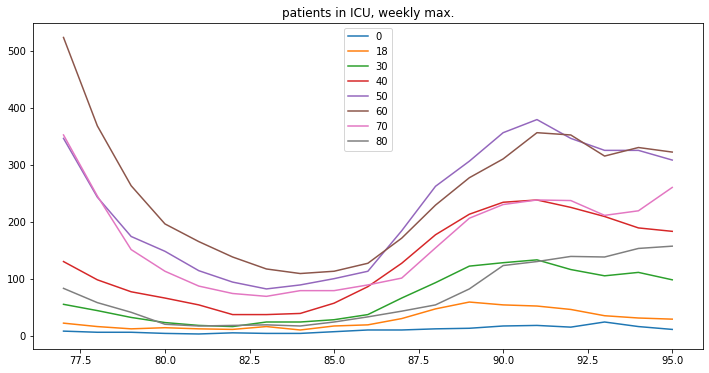

In [23]:
week_icu_max.plot()
_ = plt.title("patients in ICU, weekly max.")

AgeGroup starting 80 until week 93


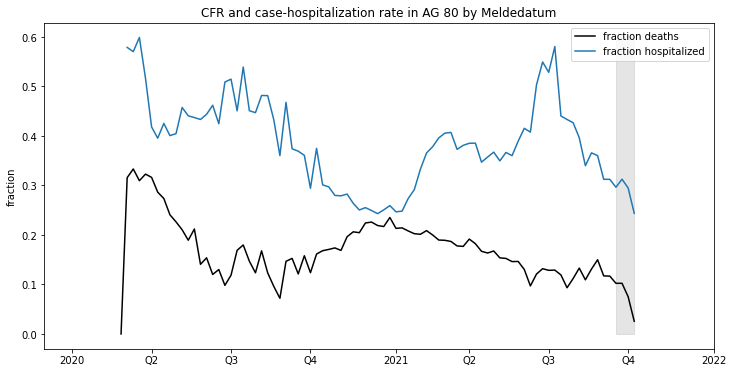

In [25]:
# Change to generate different plots
age = 80

lastweek = meldedatum_hospitalization.index[-1]
print("AgeGroup starting",age,"until week",lastweek)
c = cases.sum("sex").sel(age=age,week=range(1,lastweek+1))
plt.plot(c.coords["week"],c.sel(status="deaths")/c.sel(status="cases"),color="black",label="fraction deaths")
frac_hospital = meldedatum_hospitalization[age]/c.sel(status="cases",week=range(10,94))

plt.plot(range(10,94),frac_hospital,color="tab:blue",label="fraction hospitalized")

plt.fill_between([lastweek-3,lastweek],[0,0],[np.max(frac_hospital)]*2,alpha=.2,color="grey")

plt.xticks([1,14,27,40,54,66,79,92,53*2],labels=[2020,"Q2","Q3","Q4",2021,"Q2","Q3","Q4",2022])
plt.title("CFR and case-hospitalization rate in AG %d by Meldedatum"%age)
plt.ylabel("fraction")
plt.savefig("plots/fraction_AG%d.pdf"%age)
_ = plt.legend()

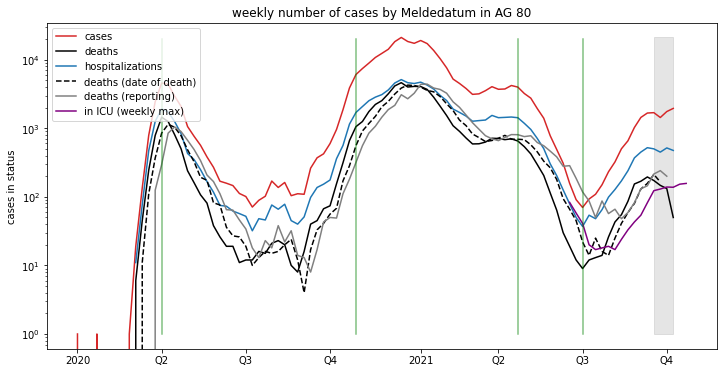

In [27]:
plt.semilogy(range(1,lastweek+1),cases.sum("sex").sel(age=age,status="cases",week=range(1,lastweek+1)),color="tab:red",label="cases")
plt.semilogy(range(1,lastweek+1),cases.sum("sex").sel(age=age,status="deaths",week=range(1,lastweek+1)),color="black",label="deaths")
plt.semilogy(meldedatum_hospitalization[age],color="tab:blue",label="hospitalizations")
if age == 80:
    wod = week_of_death[80]+week_of_death[90]
    icu = week_icu_max[80]
elif age == 60:
    wod = week_of_death[60]+week_of_death[70]
    icu = week_icu_max[60]+week_icu_max[70]
elif age == 35:
    wod = week_of_death[30]+week_of_death[40]+week_of_death[50]
    icu = week_icu_max[40]+week_icu_max[50]+week_icu_max[30]
plt.semilogy(range(10,92),wod,"k--",label="deaths (date of death)")
plt.semilogy(range(10,lastweek),reported_deaths.sel(week=range(10,lastweek),age=age).sum("sex"),"-",color="grey",label="deaths (reporting)")
plt.semilogy(icu.index,icu,"purple",label="in ICU (weekly max)")

plt.xticks([1,14,27,40,54,66,79,92,53*2],labels=[2020,"Q2","Q3","Q4",2021,"Q2","Q3","Q4",2022])
plt.fill_between([wod.index[-2],wod.index[-1]+2],[1,1],[np.max(cases.sum("sex").sel(age=age))]*2,alpha=.2,color="grey")
for x in [14,79,69,44]:
    plt.plot([x,x],[1,20000],"-",alpha=.5,color="green")
plt.legend(loc="upper left")
plt.ylabel("cases in status")
plt.title("weekly number of cases by Meldedatum in AG %d"%age)
plt.savefig("plots/casesAndStatus_AG%d.pdf"%age)